In [1]:
from datetime import datetime
import glob

import urllib
import requests
import json
import io
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import matplotlib
import pylab as pl
import datetime
import os

%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

files = glob.glob("data/*fast.csv")
from datetime import datetime as dt
# IF you run into an error in this cell, ask xtian
# there's a bug in the data
BAD_F = "data/b827ebbe2801_1521218535.02_fast.csv"
df = pd.concat(pd.read_csv(f) for f in files)

# if in python 3 there's a diff datetime.fromtime syntax here
df["timestamp"] = df["time"].apply(dt.fromtimestamp)
df = df.sort_values("timestamp")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


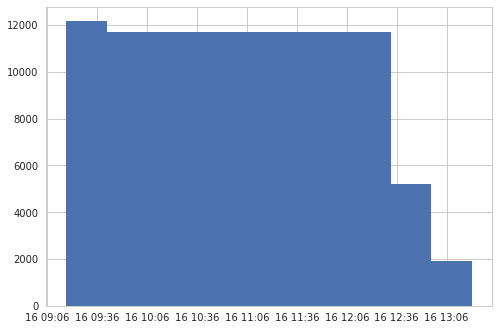

In [2]:
df["timestamp"].hist()

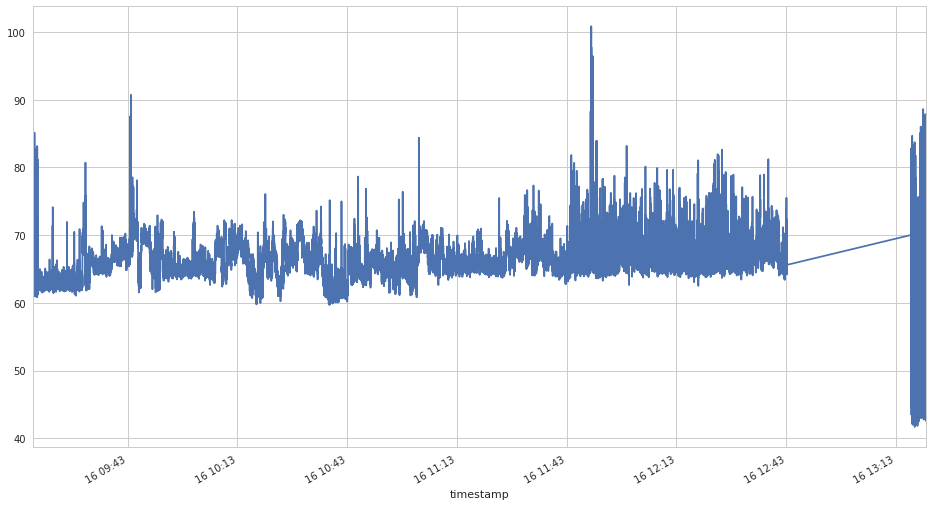

In [3]:
# march 30 2018
# df.set_index("timestamp")["dBZS"].plot(figsize=(16, 9))
df.set_index("timestamp")["dBAS"].plot(figsize=(16, 9))
# df.head()

In [4]:
df.head()

,time,dBZS,dBAS,dBCS,dBZ1_31,dBZ1_62,dBZ1_125,dBZ1_250,dBZ1_500,dBZ1_1000,...,dBZ3_3175,dBZ3_4000,dBZ3_5040,dBZ3_6350,dBZ3_8000,dBZ3_10079,dBZ3_12699,dBZ3_16000,dBZ3_20159,timestamp
0,1.521206e+09,98.27,63.74,79.60,72.81,74.27,68.44,62.96,57.74,59.08,...,48.13,46.56,45.37,47.32,39.34,36.93,37.82,38.71,42.29,2018-03-16 09:17:10.890
1,1.521206e+09,103.22,61.98,82.45,74.99,77.06,65.89,60.12,59.73,56.11,...,43.57,43.22,36.98,38.22,31.26,29.21,28.60,26.73,27.32,2018-03-16 09:17:11.020
2,1.521206e+09,102.65,61.07,80.51,72.18,70.94,66.55,61.18,59.38,54.57,...,43.43,41.77,37.34,37.44,32.21,30.17,30.18,27.76,28.65,2018-03-16 09:17:11.140
3,1.521206e+09,101.48,80.31,85.00,74.06,74.32,71.73,69.24,81.99,61.48,...,63.13,51.08,38.32,42.77,34.16,29.97,30.50,29.05,31.21,2018-03-16 09:17:11.270
4,1.521206e+09,99.93,68.96,80.37,70.75,76.49,68.08,60.39,64.53,57.35,...,60.13,55.32,50.43,52.40,41.62,43.27,36.81,29.02,30.91,2018-03-16 09:17:11.390


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250,center=False).mean()
  if __name__ == '__main__':


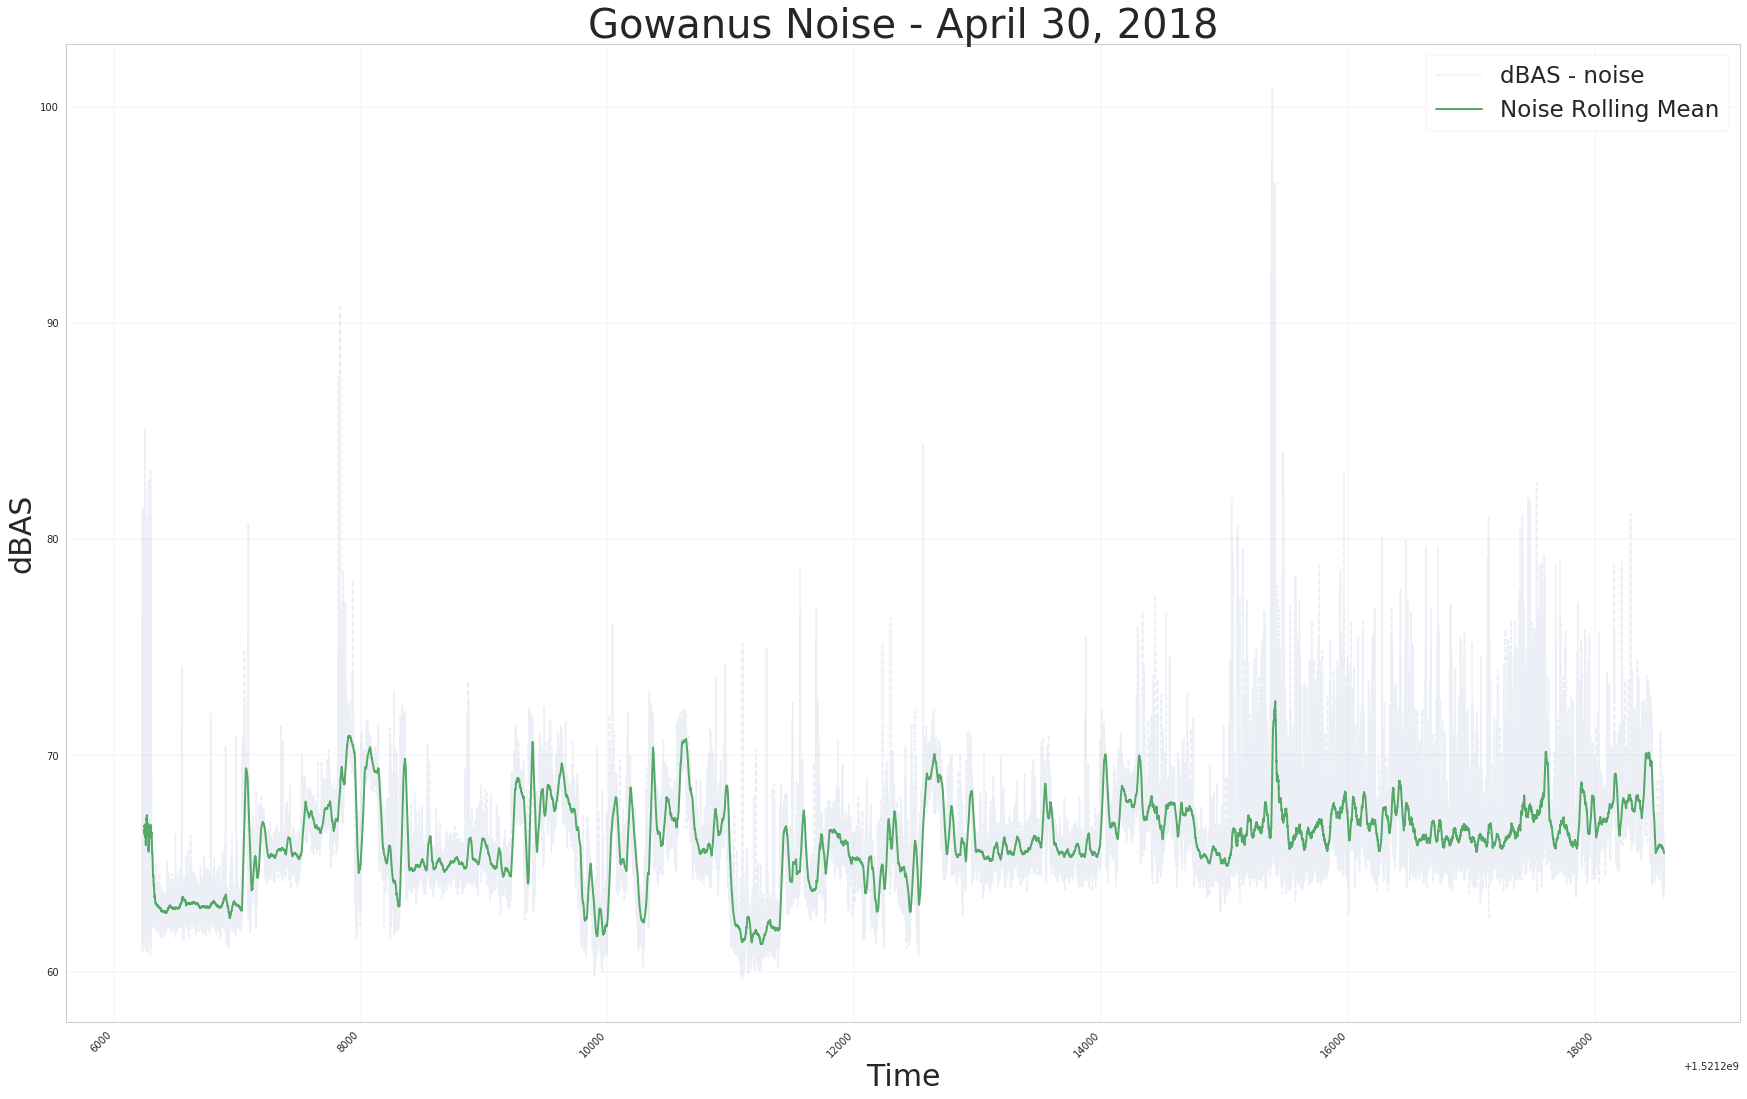

In [5]:
noise_rmean = pd.rolling_mean(df.dBAS, 250, center=False)

fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(111)

# rough guess to play with vis, cutting out last weird chunk
ax.plot(df.time[:-2200], df.dBAS[:-2200], '--', label='dBAS - noise', alpha=.1)
ax.plot(df.time[:-2200], noise_rmean[:-2200], linewidth=2, label="Noise Rolling Mean")
plt.title('Gowanus Noise - April 30, 2018', fontsize=40)
plt.ylabel('dBAS', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.legend(prop={'size': 23}, frameon=True)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(linewidth=.2)


In [6]:
# read in the log, and make the header names, dropping the first 8 rows, and resetting the index
air_df = pd.read_csv("logs/1523628079.log", header=None, names=["PM25", "PM10"])[8:].reset_index(drop=True)

# read in noise, drop dups
times_df = pd.read_csv('logs/timestamps_1523628079.log', header=None, names=['timestamps']).drop_duplicates().reset_index(drop=True)

# sanity check to make sure these are the same len
assert len(air_df)  == len(times_df)

In [7]:
# join the data on index
final_air_df = air_df.join(times_df)

# convert to datetime, and add units 
# number of seconds since jan 1 1970 (yay unix!)
final_air_df['time'] = pd.to_datetime(times_df['timestamps'], unit='s')

In [8]:
final_air_df.tail()

,PM25,PM10,timestamps,time
216,876,138,1523641357,2018-04-13 17:42:37
217,854,128,1523641416,2018-04-13 17:43:36
218,833,124,1523641476,2018-04-13 17:44:36
219,921,122,1523641535,2018-04-13 17:45:35
220,875,105,1523641594,2018-04-13 17:46:34


In [9]:
final_air_df.ix[180,3]

Timestamp('2018-04-13 17:07:08')

### This is a crazy chart!  There is way too much going on here... This is a code sample for how to create each feature, but we'll never actaully show something that's this busy(!).

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


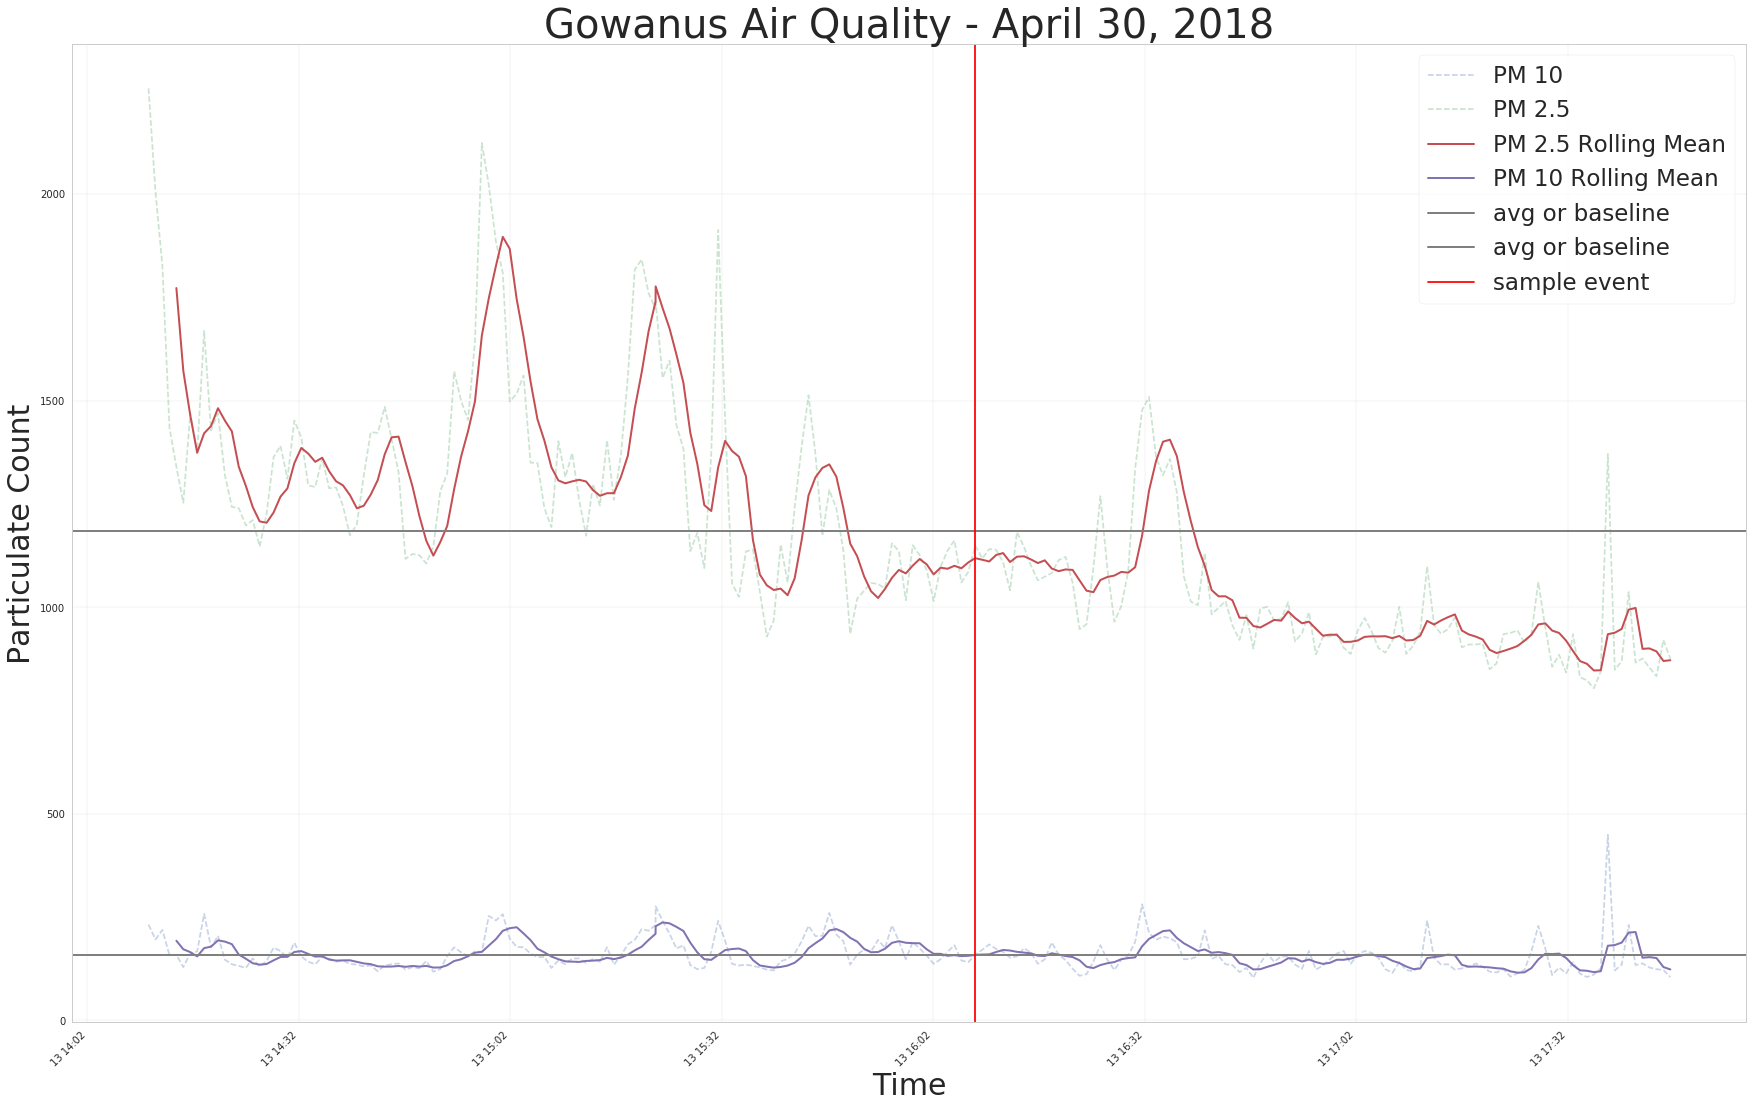

In [12]:
fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(111)

# plotting with both dataframes 
ax.plot(final_air_df.time, final_air_df.PM10, '--', label='PM 10', alpha=.3)
ax.plot(final_air_df.time, final_air_df.PM25, '--', label='PM 2.5', alpha=.3)

# define rolling means for plotting
air10_rmean = pd.rolling_mean(final_air_df.PM10, 5, center=False)
air25_rmean = pd.rolling_mean(final_air_df.PM25, 5, center=False)

# plotting with rolling means, window = 8
ax.plot(final_air_df.time, air25_rmean, linewidth=2, label="PM 2.5 Rolling Mean")
ax.plot(final_air_df.time, air10_rmean, linewidth=2, label="PM 10 Rolling Mean")

# add horintal lines for baselines/averages/whatever
plt.axhline(final_air_df.PM10.mean(), color='gray', linewidth=2, label = 'avg or baseline')
plt.axhline(final_air_df.PM25.mean(), color='gray', linewidth=2, label = 'avg or baseline')

#add verical lines for events
plt.axvline(final_air_df.ix[120,3], color='red', label= 'sample event')

plt.title('Gowanus Air Quality - April 30, 2018', fontsize=40)
plt.ylabel('Particulate Count', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.legend(prop={'size': 23}, frameon=True)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(linewidth=.2)

In [11]:
# join with noise and plot 
# normalize
# other fun stuff